# VRNN SINUS

In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1119 (delta 17), reused 0 (delta 0), pack-reused 1087
Receiving objects: 100% (1119/1119), 31.32 MiB | 33.10 MiB/s, done.
Resolving deltas: 100% (686/686), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=20898 sha256=049b810988092577b315ce65efa5cbd0ab9c0668e168fe66c24ef07d15e7f4ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9xlbl82/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [5]:
!pip install parse

  Created wheel for parse: filename=parse-1.18.0-cp36-none-any.whl size=24134 sha256=1a8be7a244f4c0c773e123a1b802e73c239256c60f26cd9eaa82d16cc1e0f10c
  Stored in directory: /root/.cache/pip/wheels/2a/53/09/869ca5781ede342254ffac09ca99461b008c3e5f8dd079b0c0
Successfully built parse


In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import numpy as np
from torchvision import datasets, transforms
import torch.distributions as td
from deepflows import Utils as utils
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
from math import log, pi, exp
from deepflows.data_generators import stochasticMovingMnist
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.nn.utils import weight_norm

In [7]:
device = utils.set_gpu(True)

# Load data 

In [8]:
class SinusWithNoise(object):
    """Data Handler that creates Bouncing MNIST dataset on the fly."""
    def __init__(self, epoch_length=1000, seq_len=20, deterministic=True, step_length=0.1, timeblocks=2, noise_variance=0.1, doublemodulation=False):
        self.seq_len = seq_len
        self.step_length = step_length
        self.deterministic = deterministic
        self.timeblocks = timeblocks
        self.std = noise_variance
        self.N = epoch_length
        self.DM = doublemodulation
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        length=self.timeblocks*self.seq_len
        x = np.arange(0,length)*self.step_length
        if self.deterministic==False:
          x= x + np.random.rand(1)*pi*2
        y = np.sin(x)
        if self.deterministic==False:
          y=y+np.random.normal(0, self.std, length)

        return np.reshape(y, [self.timeblocks, self.seq_len])

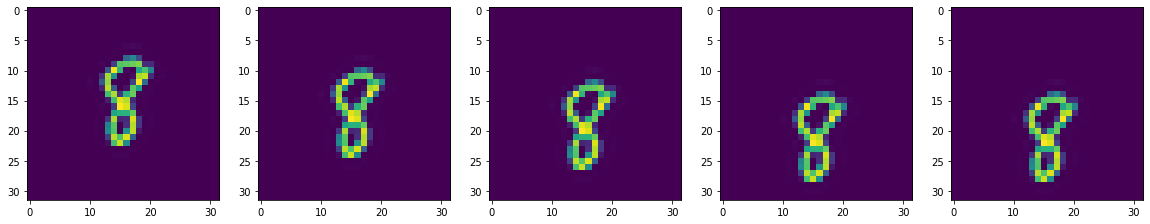

In [ ]:
batch_size = 128
data_set_type = "mnist"

n_frames = 10
three_channels = False
testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                            deterministic=False, three_channels=three_channels, step_length=2, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                              deterministic=False, three_channels=three_channels, step_length=2, normalize=False)
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
x_plot = next(iter(train_loader))[0]


fig, ax = plt.subplots(1, 5, figsize = (20,5))
ax[0].imshow(x_plot[0].squeeze(0))
ax[1].imshow(x_plot[1].squeeze(0))
ax[2].imshow(x_plot[2].squeeze(0))
ax[3].imshow(x_plot[3].squeeze(0))
ax[4].imshow(x_plot[4].squeeze(0))
plt.show()

In [13]:
class LinearLayer(nn.Module):
  def __init__(self, input, output, types="None"):
    super(LinearLayer, self).__init__()
    
    if types == 'none':
      self.net=nn.Linear(input, output)
    
    if types == 'wn':
      self.net=weight_norm(nn.Linear(input, output))

    if types == 'bn':
      self.net=nn.Sequential(nn.Linear(input, output),
                             nn.BatchNorm1d(output),)

  def forward(self,x):
    return self.net(x)


class ActFun(nn.Module):
  def __init__(self, non_lin):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU()
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20)

  def forward(self,x):
    return self.net(x)


In [ ]:
class VRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128):
    super(VRNN, self).__init__()

    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "bn"
    hidden_neurons = 512
    hidden_neurons_x_t = 256
    hidden_neurons_z_t = 512

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"), #BN here
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus()
        )
    

    self.enc = nn.Sequential(        
        LinearLayer(hidden_neurons_x_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        nn.Softplus()
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        # IF BERNOULLI LOSS
        nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_z_t + hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    self.reset_parameters()

  def forward(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    kld_loss = 0
    nll_loss =0

    for t in range(xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])

      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      # Encoder
      enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
      enc_mean_t = self.enc_mean(enc_t)
      enc_std_t = self.enc_std(enc_t)

      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      # Decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      #px=td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) #maybe x_features here
      #px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none')
      #nll_loss += px.sum(1).mean()
      nll_loss += self._nll_bernoulli(dec_mean_t, xt[:, t, :]).mean()
      

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
    return kld_loss, nll_loss

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)
   
  def sample(self, seq_len):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    sample = []
    for t in range(seq_len):

      ht = ht.view(-1, ht.shape[-1])
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      #sampling and reparameterization
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      #decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      phi_x_t = self.phi_x_t(dec_mean_t)

      #recurrence
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
      sample.append(dec_mean_t.data)
    return sample

  def prediction(self, xt, steps = 5):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
		
    bx, x_dim = xt.shape
    preds = torch.zeros(steps, bx, x_dim)
    
    for i in range(0, steps):
      preds[i] = xt
      phi_x_t = self.phi_x_t(xt)
      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     

      #sampling and reparameterization
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()
      phi_z_t = self.phi_z(z_t)

      #decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)

      #recurrence
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      xt = dec_mean_t
    return preds

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

0.001


Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 4.107411 	 NLL Loss: 55.952240


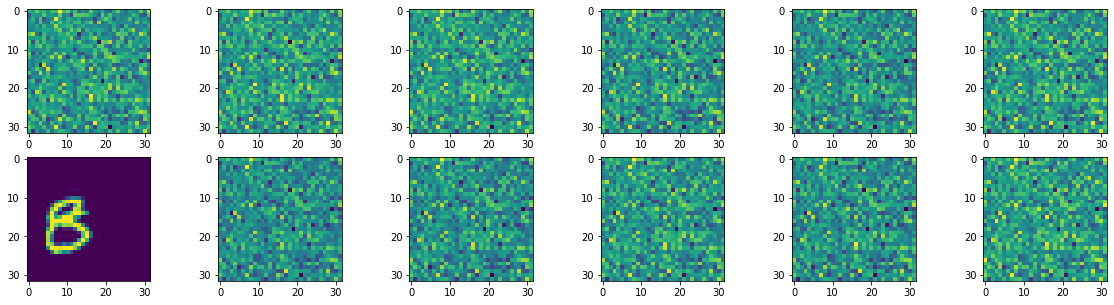

Train Epoch: 1 [12800/60000 (21%)]	 KLD Loss: 0.810247 	 NLL Loss: 10.498657


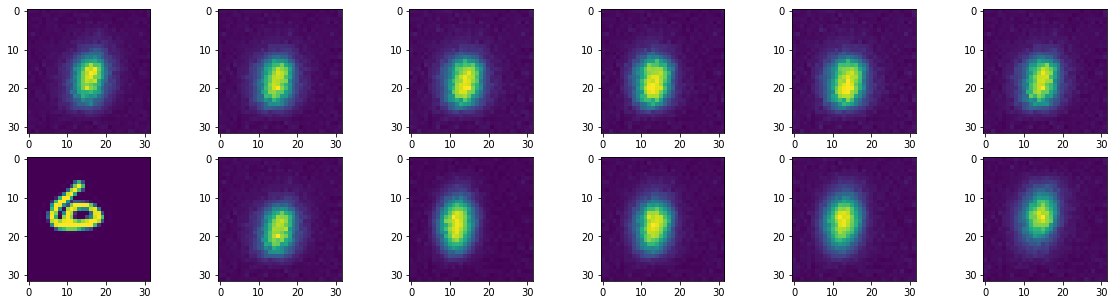

Train Epoch: 1 [25600/60000 (43%)]	 KLD Loss: 0.754055 	 NLL Loss: 8.541970


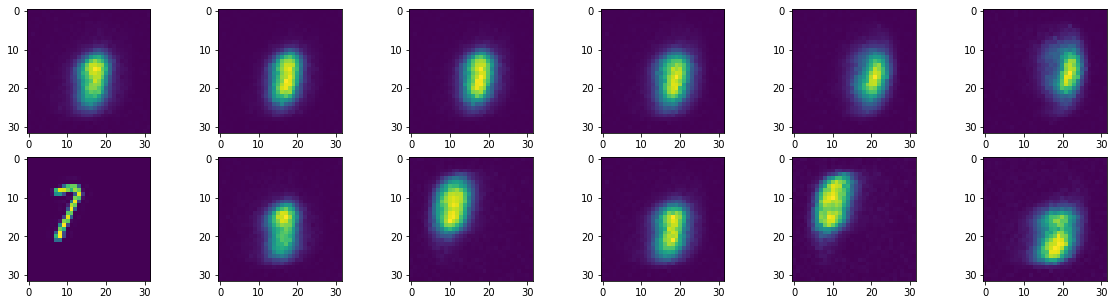

Train Epoch: 1 [38400/60000 (64%)]	 KLD Loss: 0.900411 	 NLL Loss: 7.532316


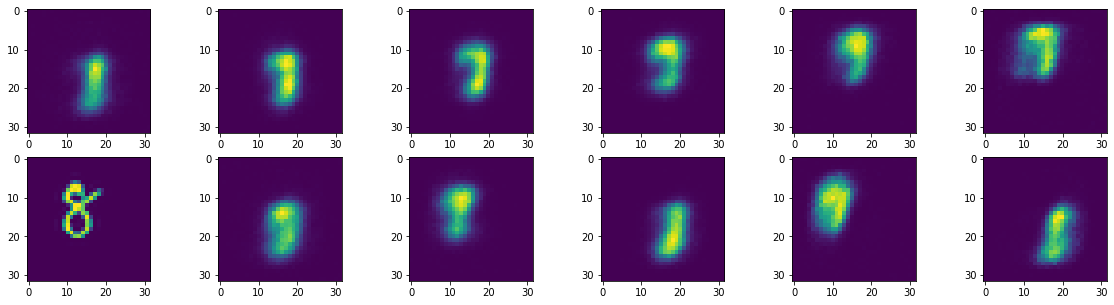

Train Epoch: 1 [51200/60000 (85%)]	 KLD Loss: 0.823481 	 NLL Loss: 6.998872


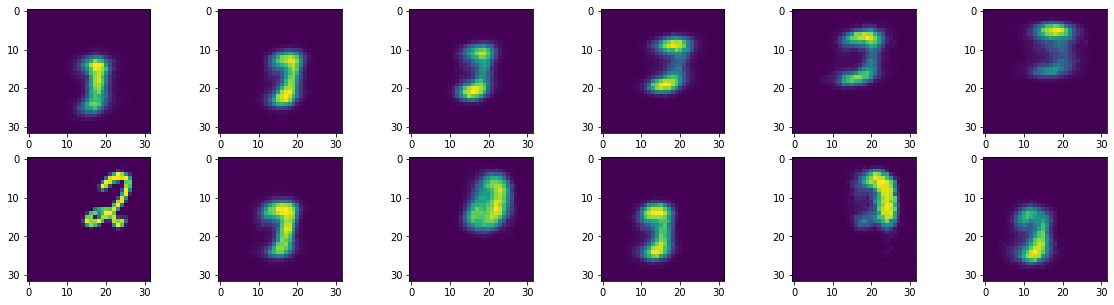

0.001


Train Epoch: 2 [0/60000 (0%)]	 KLD Loss: 0.796924 	 NLL Loss: 6.675855


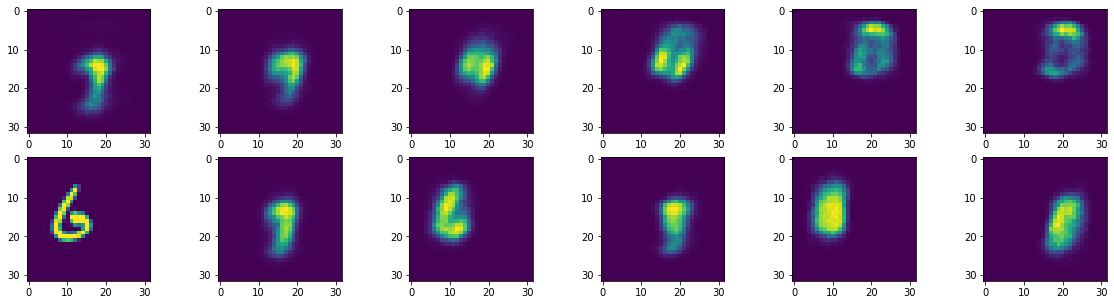

Train Epoch: 2 [12800/60000 (21%)]	 KLD Loss: 0.735489 	 NLL Loss: 6.154801


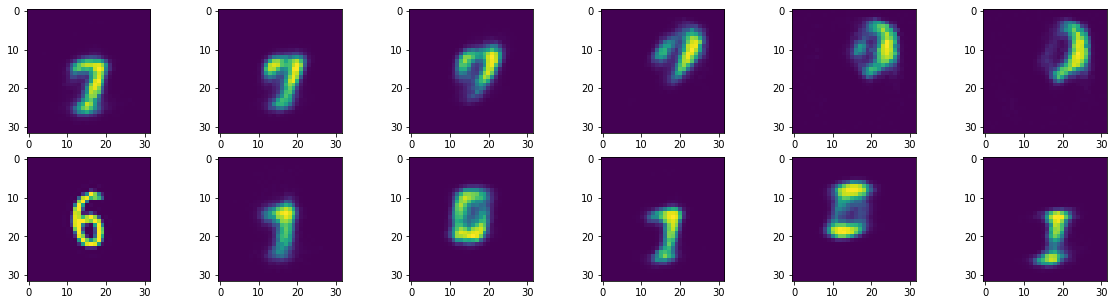

Train Epoch: 2 [25600/60000 (43%)]	 KLD Loss: 0.731059 	 NLL Loss: 6.097047


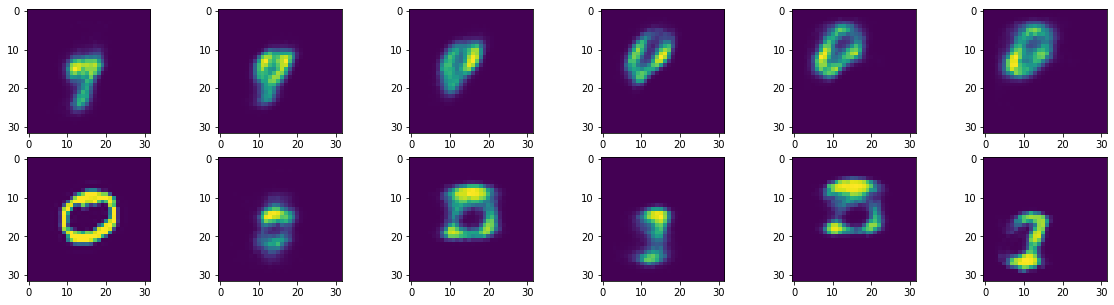

Train Epoch: 2 [38400/60000 (64%)]	 KLD Loss: 0.676791 	 NLL Loss: 5.932181


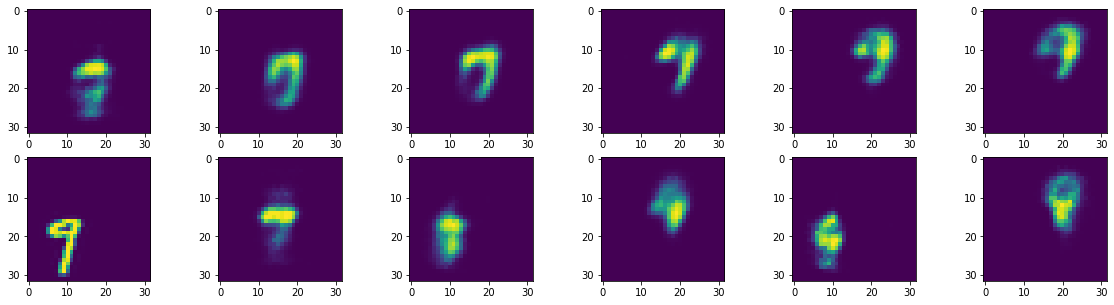

Train Epoch: 2 [51200/60000 (85%)]	 KLD Loss: 0.587958 	 NLL Loss: 5.846079


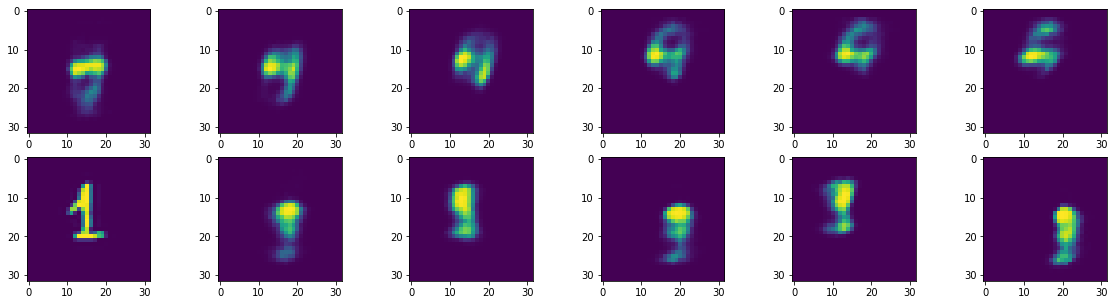

0.001


Train Epoch: 3 [0/60000 (0%)]	 KLD Loss: 0.543950 	 NLL Loss: 5.636755


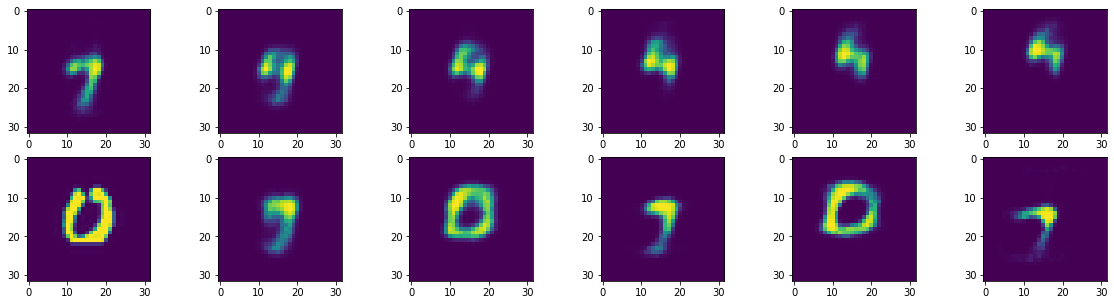

Train Epoch: 3 [12800/60000 (21%)]	 KLD Loss: 0.532563 	 NLL Loss: 5.635338


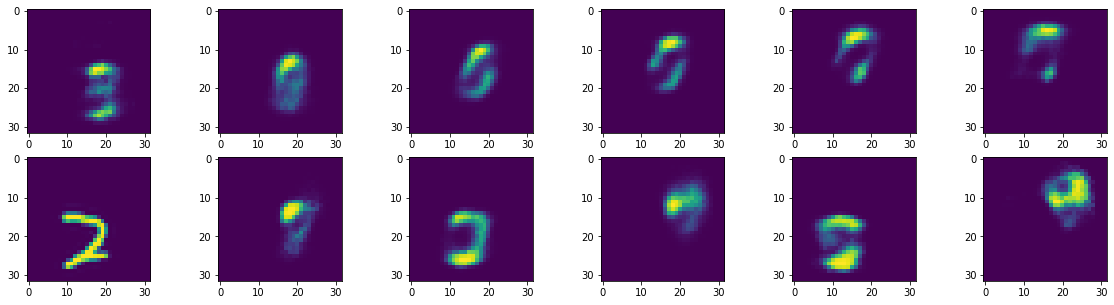

Train Epoch: 3 [25600/60000 (43%)]	 KLD Loss: 0.483779 	 NLL Loss: 5.574969


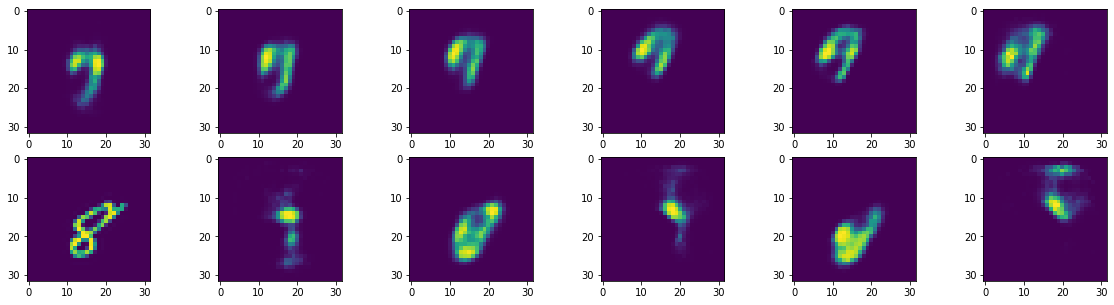

Train Epoch: 3 [38400/60000 (64%)]	 KLD Loss: 0.437497 	 NLL Loss: 5.366173


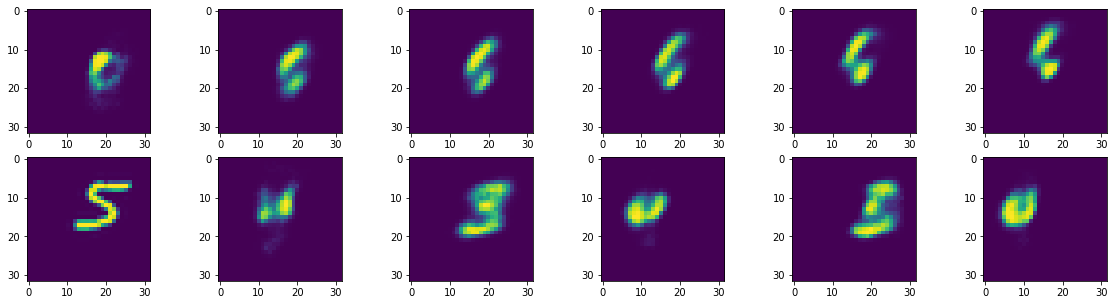

Train Epoch: 3 [51200/60000 (85%)]	 KLD Loss: 0.392618 	 NLL Loss: 5.386621


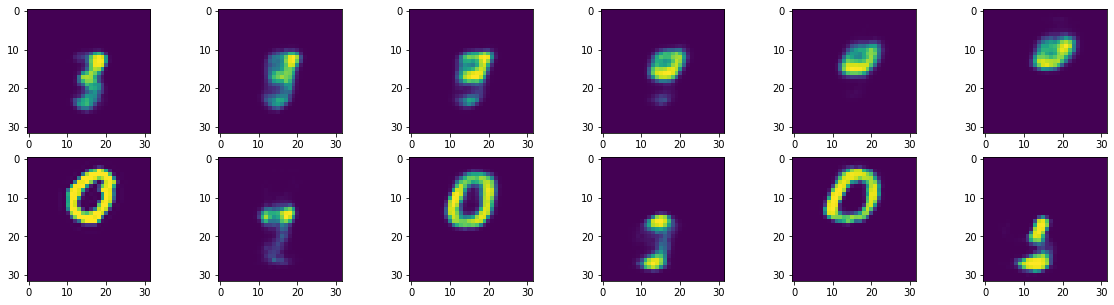

0.001


Train Epoch: 4 [0/60000 (0%)]	 KLD Loss: 0.372308 	 NLL Loss: 5.631386


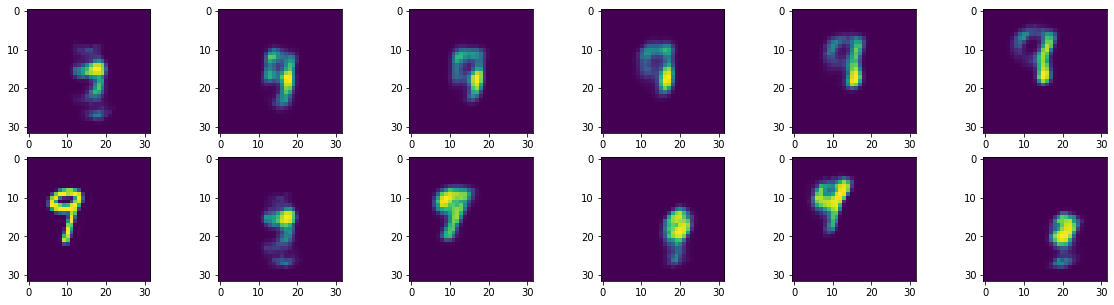

Train Epoch: 4 [12800/60000 (21%)]	 KLD Loss: 0.351896 	 NLL Loss: 5.251083


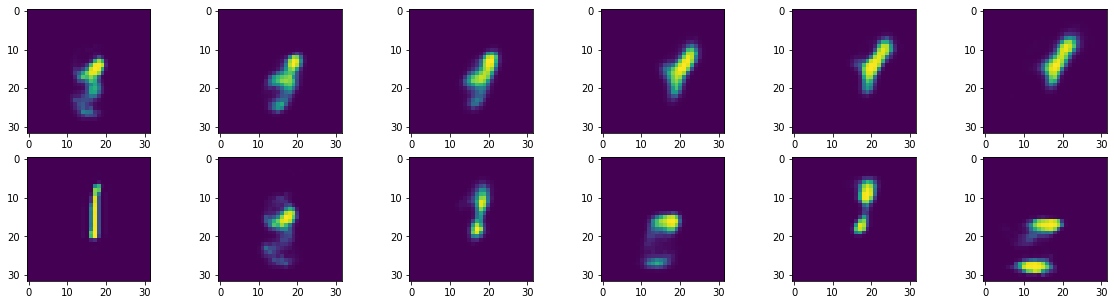

Train Epoch: 4 [25600/60000 (43%)]	 KLD Loss: 0.329143 	 NLL Loss: 5.199382


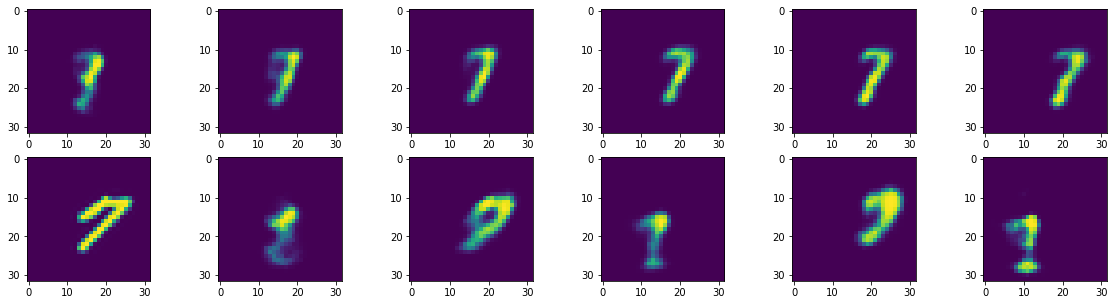

Train Epoch: 4 [38400/60000 (64%)]	 KLD Loss: 0.335088 	 NLL Loss: 5.335949


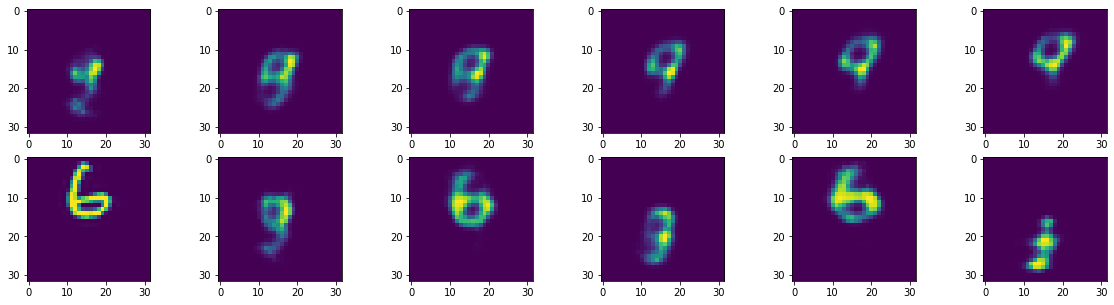

Train Epoch: 4 [51200/60000 (85%)]	 KLD Loss: 0.324139 	 NLL Loss: 5.121555


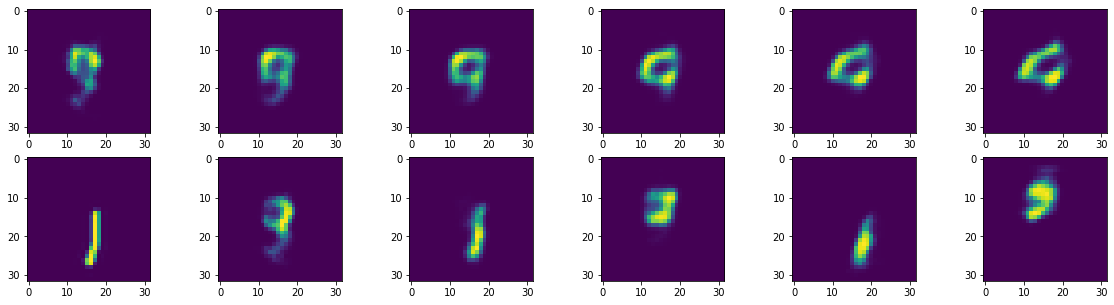

0.001


Train Epoch: 5 [0/60000 (0%)]	 KLD Loss: 0.319134 	 NLL Loss: 5.240595


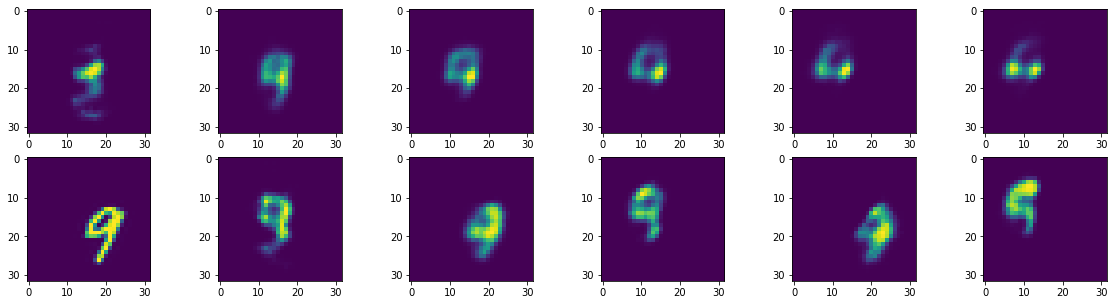

Train Epoch: 5 [12800/60000 (21%)]	 KLD Loss: 0.322745 	 NLL Loss: 5.228895


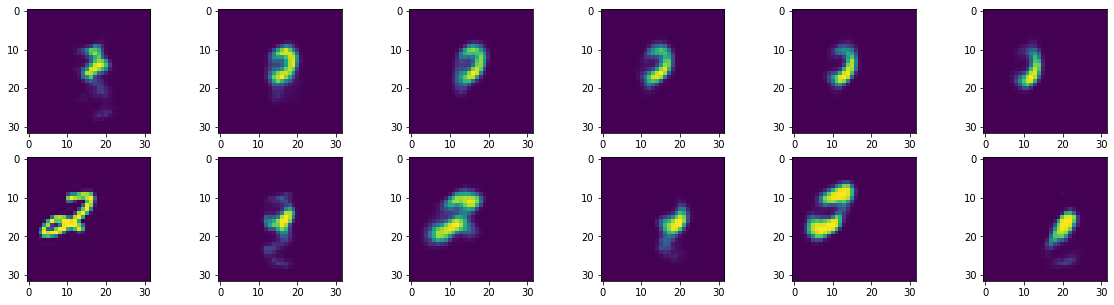

Train Epoch: 5 [25600/60000 (43%)]	 KLD Loss: 0.311479 	 NLL Loss: 5.087512


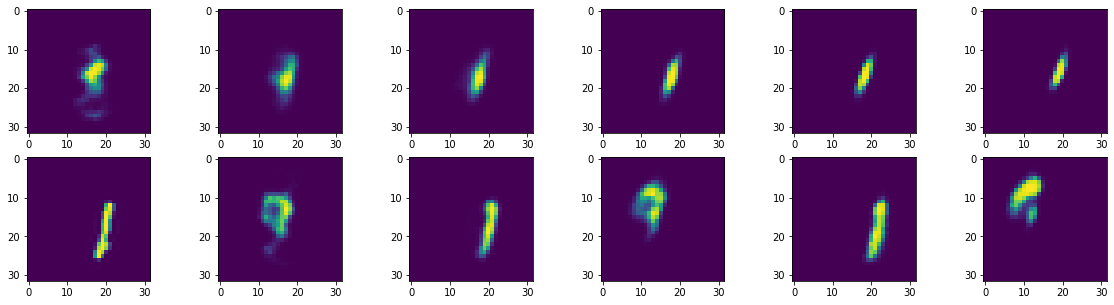

Train Epoch: 5 [38400/60000 (64%)]	 KLD Loss: 0.306300 	 NLL Loss: 5.028621


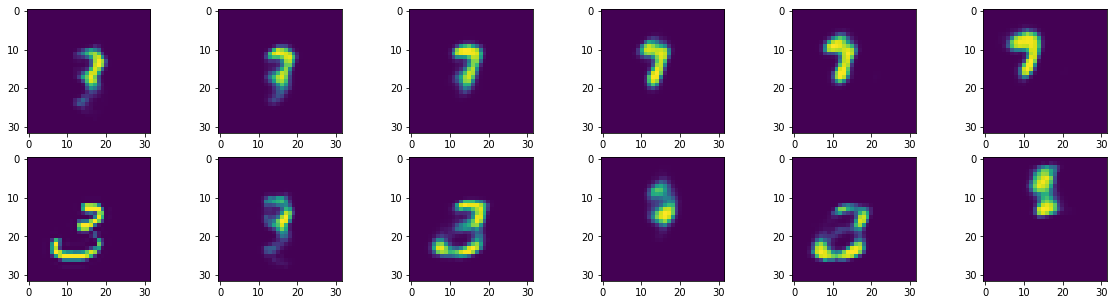

Train Epoch: 5 [51200/60000 (85%)]	 KLD Loss: 0.306396 	 NLL Loss: 5.050682


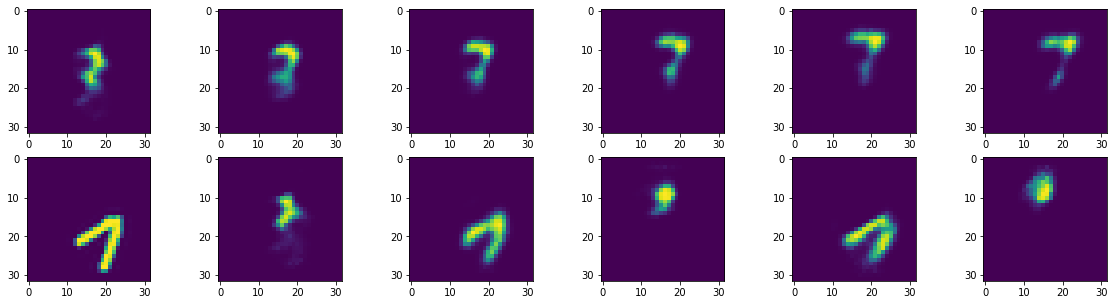

0.001


Train Epoch: 6 [0/60000 (0%)]	 KLD Loss: 0.312057 	 NLL Loss: 5.049263


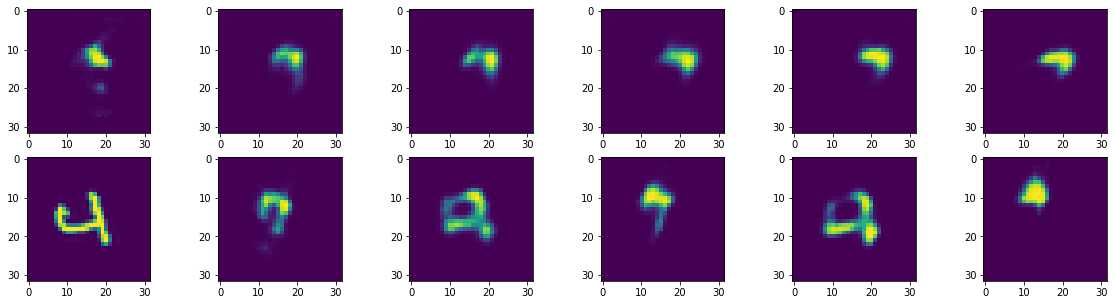

Train Epoch: 6 [12800/60000 (21%)]	 KLD Loss: 0.301168 	 NLL Loss: 4.825545


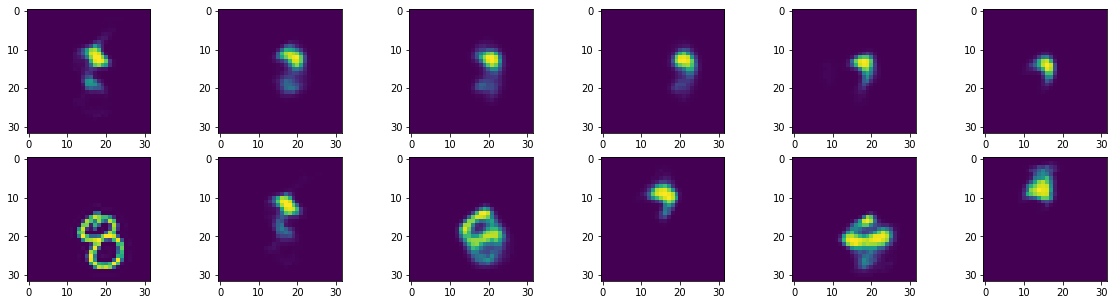

Train Epoch: 6 [25600/60000 (43%)]	 KLD Loss: 0.294301 	 NLL Loss: 4.980534


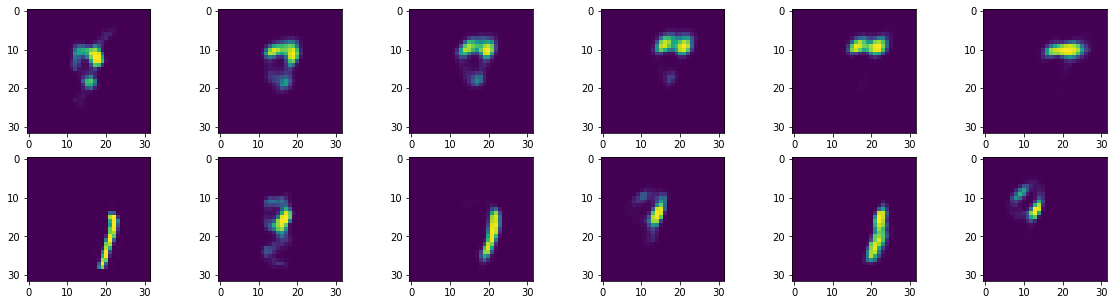

Train Epoch: 6 [38400/60000 (64%)]	 KLD Loss: 0.293344 	 NLL Loss: 4.772177


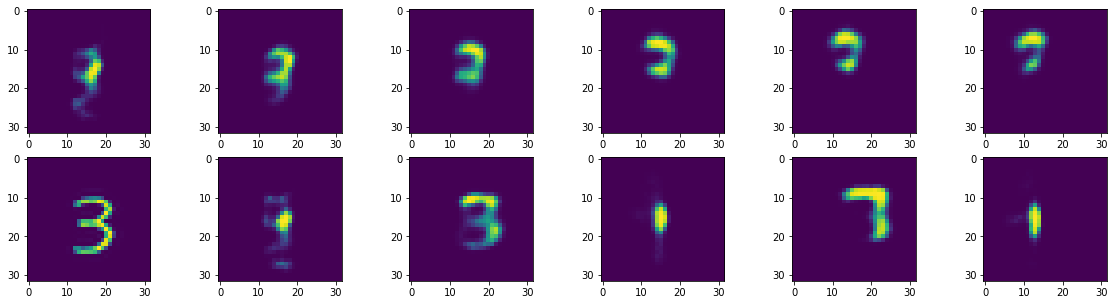

Train Epoch: 6 [51200/60000 (85%)]	 KLD Loss: 0.292524 	 NLL Loss: 4.832056


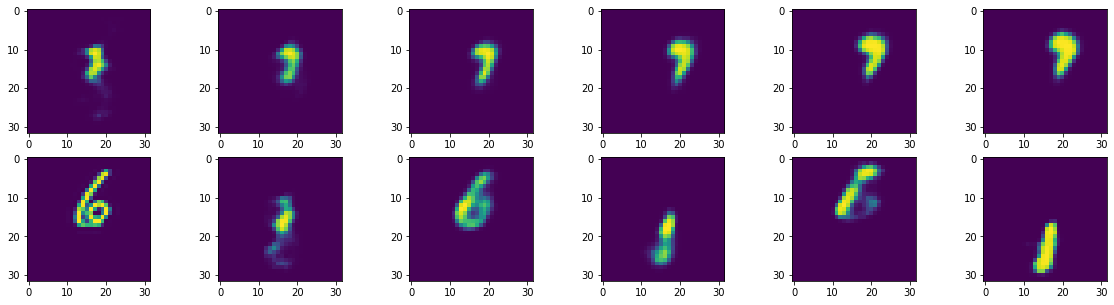

0.0005


Train Epoch: 7 [0/60000 (0%)]	 KLD Loss: 0.288540 	 NLL Loss: 4.884655


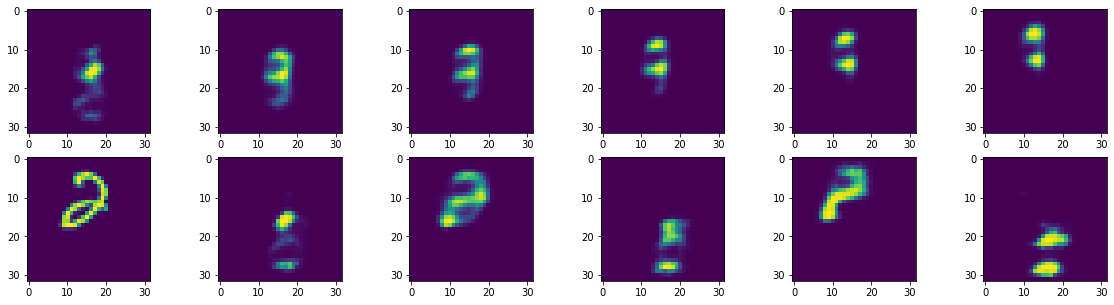

Train Epoch: 7 [12800/60000 (21%)]	 KLD Loss: 0.277050 	 NLL Loss: 4.913161


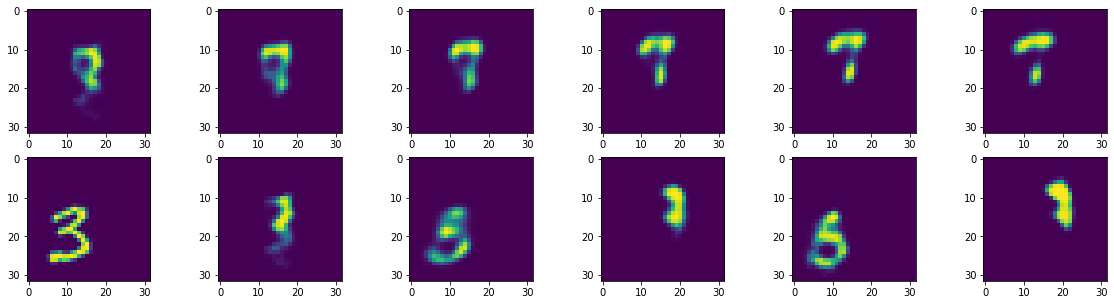

Train Epoch: 7 [25600/60000 (43%)]	 KLD Loss: 0.289194 	 NLL Loss: 5.012887


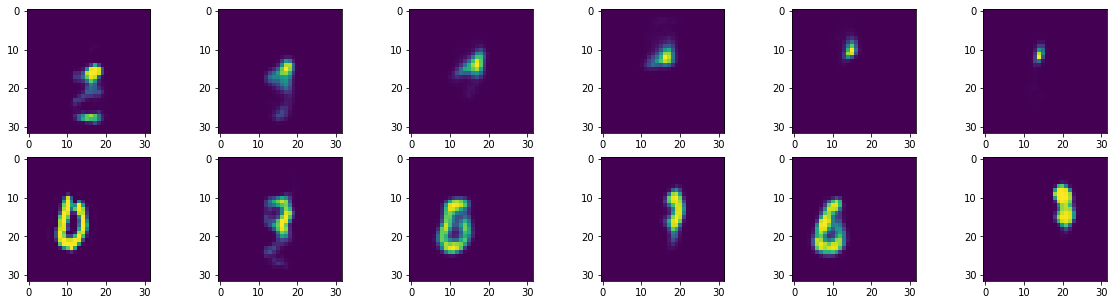

Train Epoch: 7 [38400/60000 (64%)]	 KLD Loss: 0.278151 	 NLL Loss: 4.934453


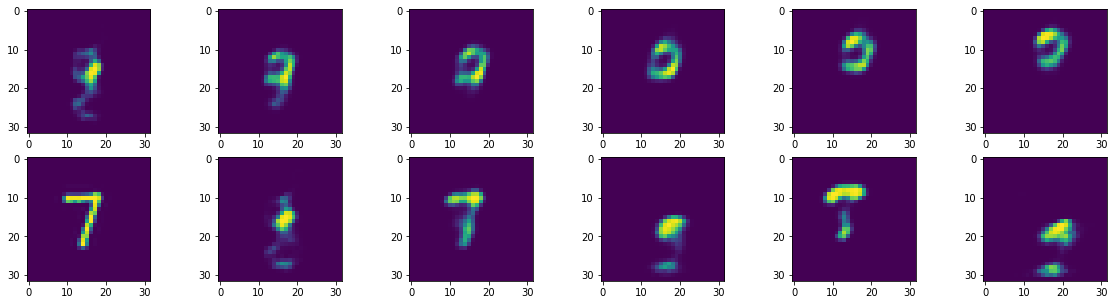

Train Epoch: 7 [51200/60000 (85%)]	 KLD Loss: 0.268250 	 NLL Loss: 4.824296


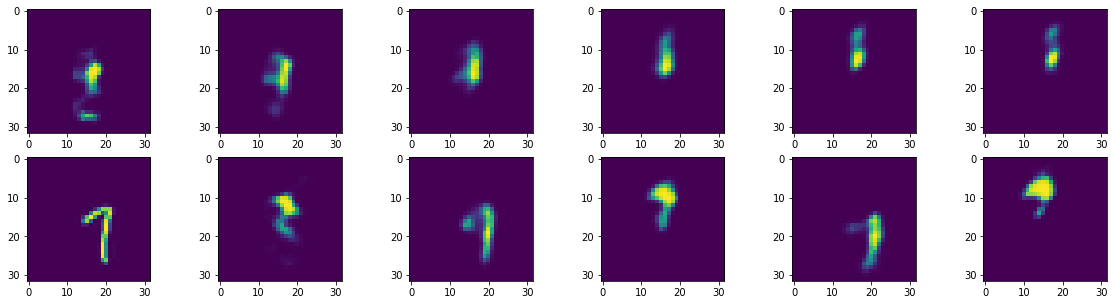

0.0005


Train Epoch: 8 [0/60000 (0%)]	 KLD Loss: 0.276854 	 NLL Loss: 5.030075


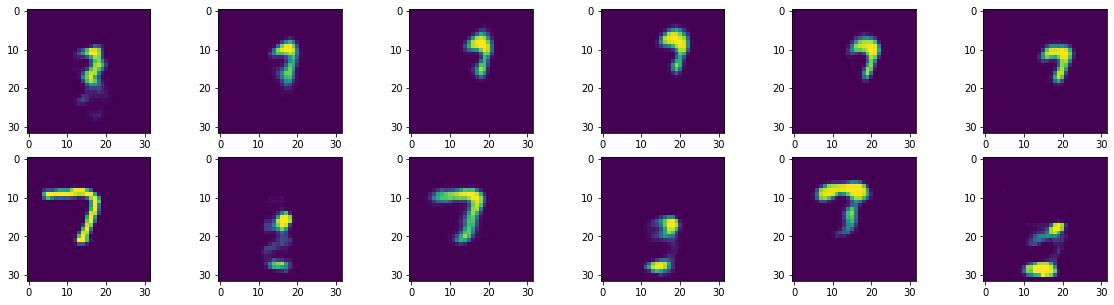

Train Epoch: 8 [12800/60000 (21%)]	 KLD Loss: 0.278262 	 NLL Loss: 4.826506


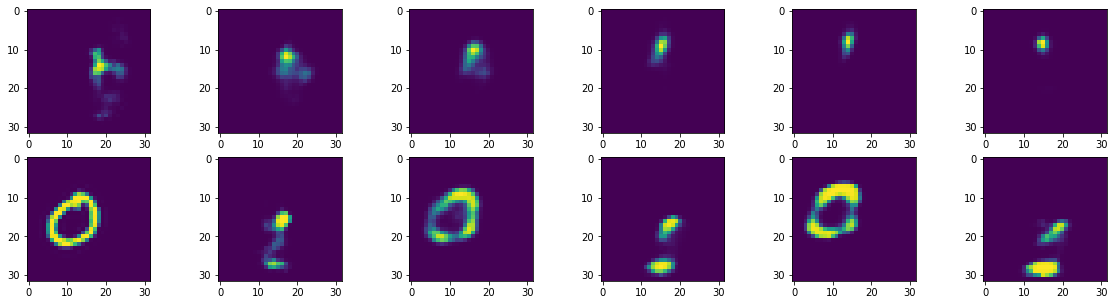

Train Epoch: 8 [25600/60000 (43%)]	 KLD Loss: 0.278288 	 NLL Loss: 4.818751


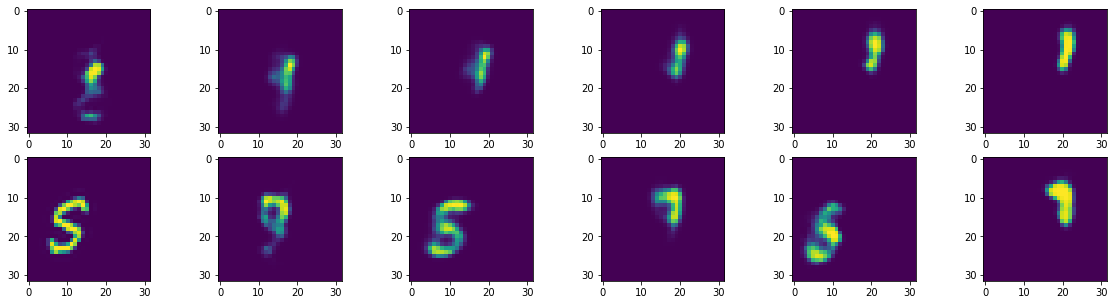

Train Epoch: 8 [38400/60000 (64%)]	 KLD Loss: 0.281919 	 NLL Loss: 4.743754


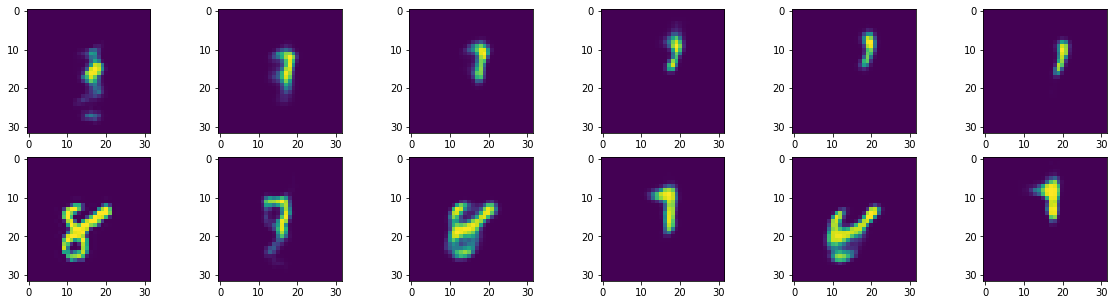

Train Epoch: 8 [51200/60000 (85%)]	 KLD Loss: 0.272166 	 NLL Loss: 4.583086


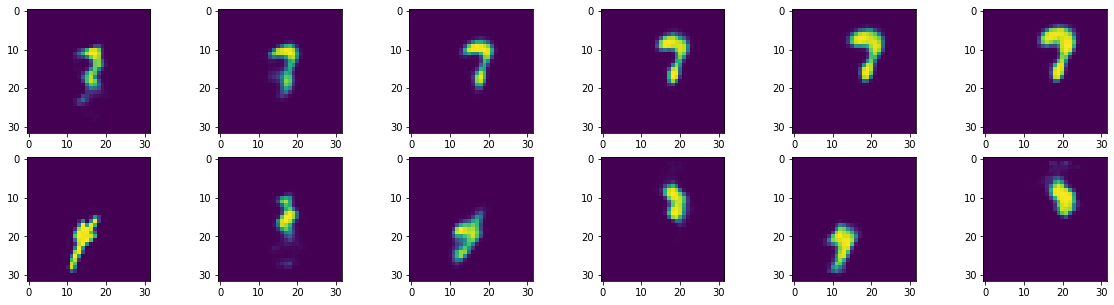

0.00025


Train Epoch: 9 [0/60000 (0%)]	 KLD Loss: 0.273628 	 NLL Loss: 4.739944


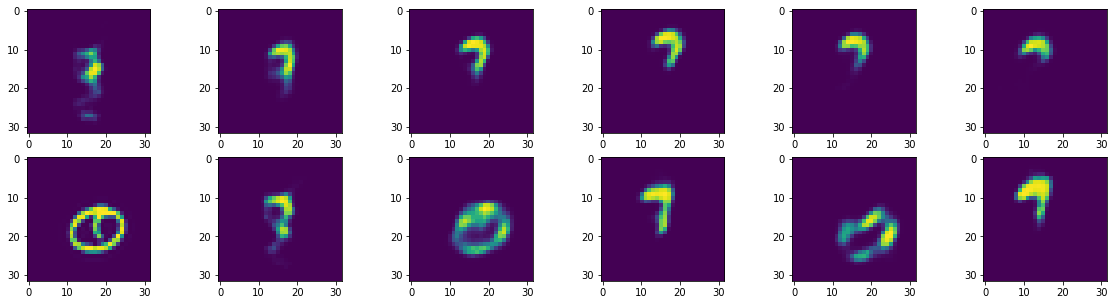

Train Epoch: 9 [12800/60000 (21%)]	 KLD Loss: 0.268577 	 NLL Loss: 4.808133


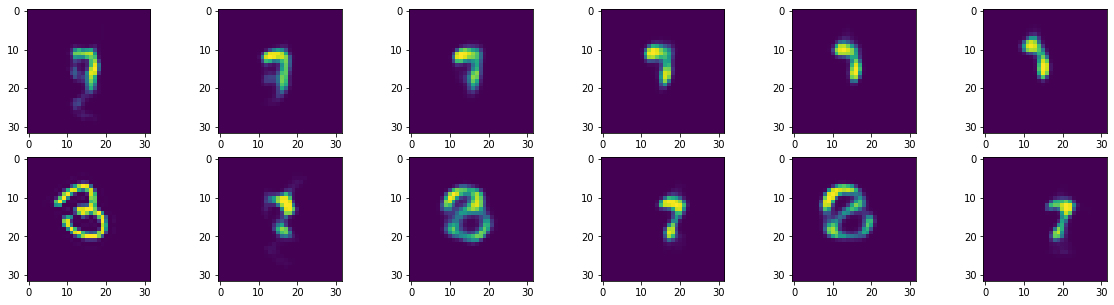

Train Epoch: 9 [25600/60000 (43%)]	 KLD Loss: 0.268339 	 NLL Loss: 4.899042


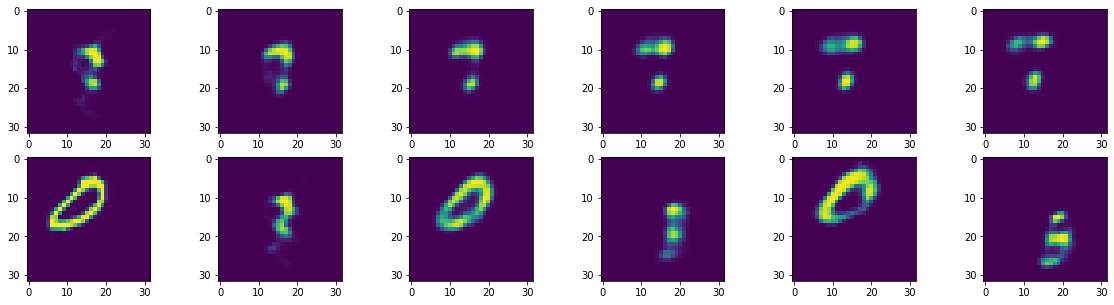

Train Epoch: 9 [38400/60000 (64%)]	 KLD Loss: 0.273995 	 NLL Loss: 4.675484


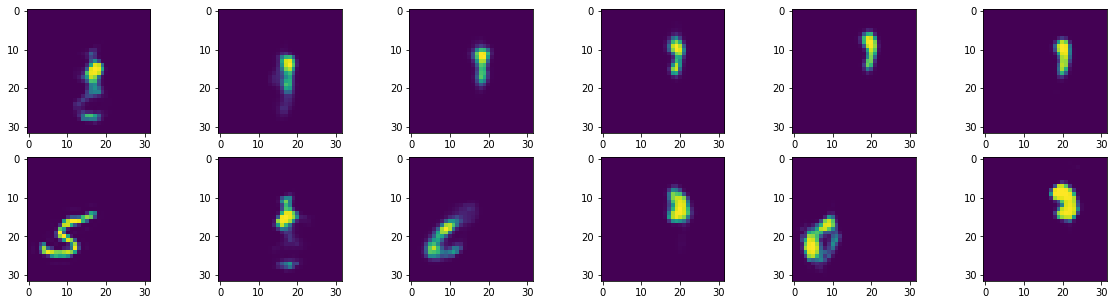

Train Epoch: 9 [51200/60000 (85%)]	 KLD Loss: 0.272214 	 NLL Loss: 4.788010


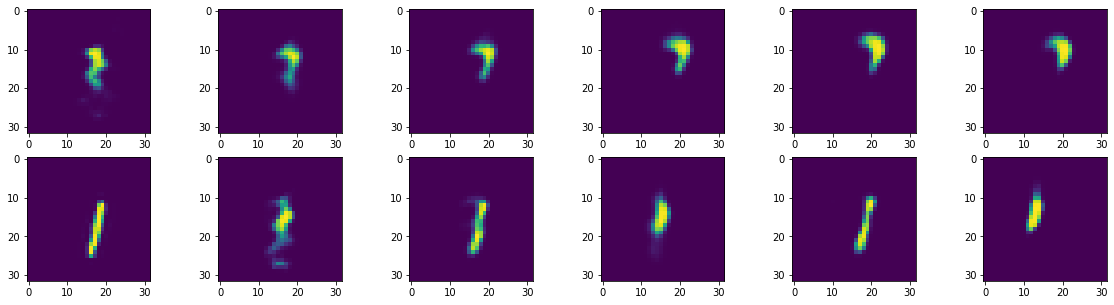

0.000125


Train Epoch: 10 [0/60000 (0%)]	 KLD Loss: 0.271496 	 NLL Loss: 4.897951


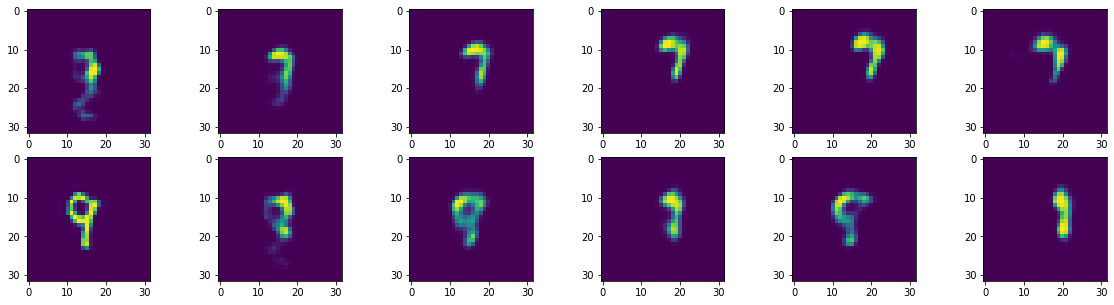

Train Epoch: 10 [12800/60000 (21%)]	 KLD Loss: 0.266349 	 NLL Loss: 4.680593


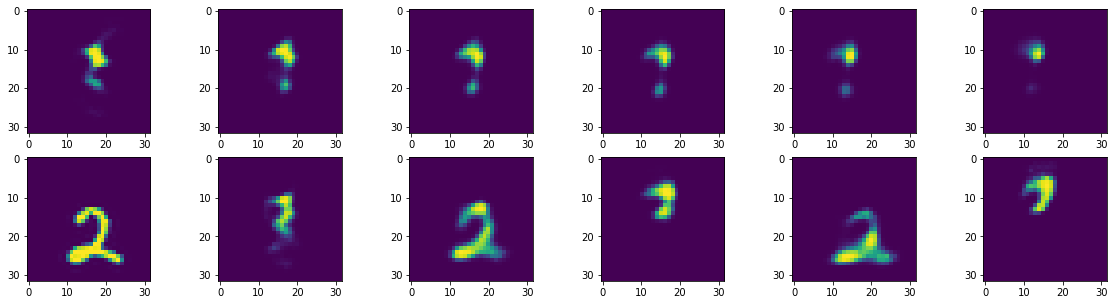

KeyboardInterrupt: ignored

In [ ]:
x=next(iter(train_loader)).float().to(device)
x=x.view(batch_size, n_frames, -1)

model = VRNN(x.shape[-1], x_batch=x.shape[0], h_dim = 512, z_dim = 256).to(device) #hdim 256

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print_every = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=250, factor = 0.5)
clip = 10
n_epochs = 10
counter = 0

for epoch in range(1, n_epochs + 1):
  print(optimizer.param_groups[0]['lr'])
  for batch_idx, data in enumerate(tqdm(train_loader, desc='Batch', leave=False)):

    data = data.to(device)
    data = (data - data.min()) / (data.max() - data.min())
    data=data.view(batch_size, n_frames, -1)
    
    #Warm up
    beta = min(1, 0.001 + (counter+1)/1500)
    counter += 1
    
    optimizer.zero_grad()
    kld_loss, nll_loss = model(data)
    loss = beta*kld_loss + nll_loss
    loss.backward()
    optimizer.step()

    nn.utils.clip_grad_norm_(model.parameters(), clip)
    scheduler.step(loss)

    #printing
    with torch.no_grad():
      model.eval()
      if batch_idx % print_every == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(epoch, batch_idx * len(data), 
                                                                                                len(train_loader.dataset),
                                                                                                100. * batch_idx / len(train_loader),
                                                                                                kld_loss / batch_size, 
                                                                                                nll_loss / batch_size))
        sample = model.sample(10)
        fig, ax = plt.subplots(2, 6, figsize = (20,5))
        ax[0,0].imshow(sample[0][0].view(32,32).detach().cpu().numpy())
        ax[0,1].imshow(sample[1][0].view(32,32).detach().cpu().numpy())
        ax[0,2].imshow(sample[2][0].view(32,32).detach().cpu().numpy())
        ax[0,3].imshow(sample[3][0].view(32,32).detach().cpu().numpy())
        ax[0,4].imshow(sample[4][0].view(32,32).detach().cpu().numpy())
        ax[0,5].imshow(sample[5][0].view(32,32).detach().cpu().numpy())

        preds = model.prediction(data[:, 0, :], steps=6)
        ax[1,0].imshow(preds[0][0].view(32,32).detach().cpu().numpy())
        ax[1,1].imshow(preds[1][0].view(32,32).detach().cpu().numpy())
        ax[1,2].imshow(preds[2][0].view(32,32).detach().cpu().numpy())
        ax[1,3].imshow(preds[3][0].view(32,32).detach().cpu().numpy())
        ax[1,4].imshow(preds[4][0].view(32,32).detach().cpu().numpy())
        ax[1,5].imshow(preds[5][0].view(32,32).detach().cpu().numpy())
        plt.pause(1e-6)
    model.train()

In [9]:
class VRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128):
    super(VRNN, self).__init__()

    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "bn"
    hidden_neurons = 256
    hidden_neurons_x_t = 100
    hidden_neurons_z_t = 100

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus()
        )
    

    self.enc = nn.Sequential(        
        LinearLayer(hidden_neurons_x_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        nn.Softplus()
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        
        #nn.Tanh()
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_z_t + hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    self.reset_parameters()

  def forward(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    kld_loss = 0
    nll_loss =0

    for t in range(xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])
      
      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      # Encoder
      enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
      enc_mean_t = self.enc_mean(enc_t)
      enc_std_t = self.enc_std(enc_t)

      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      # Decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      # px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none') #USE SIGMOID IN DECODER MEAN OUTPUT
      # px = F.mse_loss(dec_mean_t, xt[:, t, :], reduction='none') #USE TANH IN DECODER MEAN OUTPUT
      
      nll_loss += px.sum(1).mean()
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
    return kld_loss, nll_loss

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

  
  def OnestepPredict(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    
    data_list = []

    sample=[]
    for i in range(0, xt.shape[1]):
      xt_features = self.phi_x_t(xt[:, i, :])
      ht=ht.view(self.x_batch, -1)

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      
      # dec_mean_t for other losses than normal dist
      sample.append(x_sample)
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) #LSTM
      
    return sample

  def PredictionAfterTsteps(self, xt, tsteps=6):

    if xt.shape[1] < tsteps:
      assert 'Predictions are dependent on x, so x must be larger than tsteps'
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    data_list = []
    predictions=[]
    
    for i in range(0, tsteps):

      xt_features = self.phi_x_t(xt[:, i, :])

      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) # LSTM
      
    
    
    for i in range(tsteps,xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht=ht.view(self.x_batch,-1)
      
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) 
    return predictions

In [28]:
class SRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128):
    super(SRNN, self).__init__()

    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "bn"
    hidden_neurons = 256
    hidden_neurons_x_t = 100
    hidden_neurons_z_t = 100

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim + z_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus()
        )
    

    self.enc = nn.Sequential(        
        LinearLayer(hidden_neurons_x_t + n_layers*h_dim + z_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        nn.Softplus()
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        
        #nn.Tanh()
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_z_t + hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    self.reset_parameters()

  def forward(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    z_tp = Variable(torch.zeros(self.x_batch, self.z_dim)).to(device)
    z_t = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    kld_loss = 0
    nll_loss =0

    for t in range(xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])

      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(torch.cat([ht, z_tp], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)
      z_tp = td.Normal(prior_mean_t, prior_std_t).rsample()

      # Encoder
      enc_t = self.enc(torch.cat([phi_x_t, ht, z_t], 1))
      enc_mean_t = self.enc_mean(enc_t)
      enc_std_t = self.enc_std(enc_t)

      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      # Decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      # px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none') #USE SIGMOID IN DECODER MEAN OUTPUT
      # px = F.mse_loss(dec_mean_t, xt[:, t, :], reduction='none') #USE TANH IN DECODER MEAN OUTPUT
      
      nll_loss += px.sum(1).mean()
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
    return kld_loss, nll_loss

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

  
  def OnestepPredict(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    z_t = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
    data_list = []

    sample=[]
    for i in range(0, xt.shape[1]):
      xt_features = self.phi_x_t(xt[:, i, :])
      ht=ht.view(self.x_batch, -1)

      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      
      # dec_mean_t for other losses than normal dist
      sample.append(x_sample)
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) #LSTM
      
    return sample

  def PredictionAfterTsteps(self, xt, tsteps=6):

    if xt.shape[1] < tsteps:
      assert 'Predictions are dependent on x, so x must be larger than tsteps'
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    z_t = Variable(torch.zeros(self.x_batch, self.z_dim)).to(device)
    data_list = []
    predictions=[]
    
    for i in range(0, tsteps):

      xt_features = self.phi_x_t(xt[:, i, :])

      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) # LSTM
      
    
    
    for i in range(tsteps,xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht=ht.view(self.x_batch,-1)
      
      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) 
    return predictions

In [23]:
seq_len = 100
batch_size = 64
noisevar = 0.1
timeblocks = 30
step_len = 0.05
trainset = SinusWithNoise(epoch_length=5000, seq_len=seq_len, deterministic=False, step_length=step_len, timeblocks=timeblocks, noise_variance=noisevar)
train_loader_sinus = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
testset = SinusWithNoise(epoch_length=100, seq_len=seq_len, deterministic=False, step_length=step_len, timeblocks=timeblocks, noise_variance=noisevar)
test_loader_sinus = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True)

In [24]:
def scale_to_zero_one(x, scaler, reverse=False, transform=True):
  if transform == False:
    return x
  
  if reverse == False:
    x=(x - scaler.min()) / (scaler.max() - scaler.min())
  else:
    x= x*(scaler.max() - scaler.min())+scaler.min()
  return x

In [29]:
def trainer(model, print_every, clip, n_epochs):
  counter = 0
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor = 0.5)


  transform_x = False
  lossKLD_hist=[]
  lossNLL_hist=[]

  for epoch in range(1, n_epochs + 1):
    print(optimizer.param_groups[0]['lr'])
    train_loss = []
    for batch_idx, data in enumerate(tqdm(train_loader_sinus, desc='Batch', leave=False)):

      data = data.float().to(device)
      data = scale_to_zero_one(data, data, reverse=False, transform=transform_x)
      data=data.view(batch_size, timeblocks, -1)
      
      #Warm up
      beta = 1
      counter += 1
      
      optimizer.zero_grad()
      kld_loss, nll_loss = model(data)
      loss = beta*kld_loss + nll_loss
      loss.backward()
      optimizer.step()

      nn.utils.clip_grad_norm_(model.parameters(), clip)
      if batch_idx % 20 == 0: #Test every 20 batch to make sure the change has a change to work
        scheduler.step(loss)

      train_loss.append(loss.detach().cpu().numpy())
      lossKLD_hist.append(beta*kld_loss.detach().cpu().numpy())
      lossNLL_hist.append(nll_loss.detach().cpu().numpy())

      if batch_idx % print_every == 0:
        with torch.no_grad():
          model.eval()

          xtest=next(iter(test_loader_sinus)).to(device)
          xtest = scale_to_zero_one(xtest, xtest, reverse=False, transform=transform_x)

          print('Epoch Loss: ' + str(np.array(train_loss).mean()))
          
          sample = model.OnestepPredict(xtest.float())
          fig, ax = plt.subplots(2, 10, figsize = (20,5))
          for i in range(0,10):
            
            ax[0,i].plot(scale_to_zero_one(sample[i][0], xtest, reverse=True, transform=transform_x).cpu().numpy())
            ax[0,i].plot(scale_to_zero_one(xtest[0][i], xtest, reverse=True, transform=transform_x).cpu().numpy())

          for i in range(0,10):

            ax[1,i].plot(scale_to_zero_one(sample[i+10][0], xtest, reverse=True, transform=transform_x).cpu().numpy())
            ax[1,i].plot(scale_to_zero_one(xtest[0][i+10], xtest, reverse=True, transform=transform_x).cpu().numpy())
          
          tsteps=3*timeblocks//4
          preds = model.PredictionAfterTsteps(xtest.float(), tsteps=tsteps)
          predictions=[]
          for i in range(0,len(preds)):
            #predsher= scale_to_zero_one(preds[i][0], xtest, reverse=True, transform=transform_x)
            predictions.append(preds[i][0].cpu().numpy())

          plt.figure(figsize=(20,5))
          plt.plot(np.ravel(np.array(predictions)),label='Predictions')
          plt.plot(xtest.view(batch_size,-1)[0].cpu(),label='True')
          plt.axvline(x=xtest[0,:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
          plt.legend()

          fig, ax = plt.subplots(1, 2, figsize = (20,5))
          ax[0].plot(lossKLD_hist)
          ax[0].grid()
          ax[0].title.set_text('KLD Loss')
          ax[1].plot(lossNLL_hist)
          ax[1].title.set_text('NLL-loss')
          plt.show()
        model.train()
  return model, lossKLD_hist, lossNLL_hist



0.001


Epoch Loss: 3519.9165


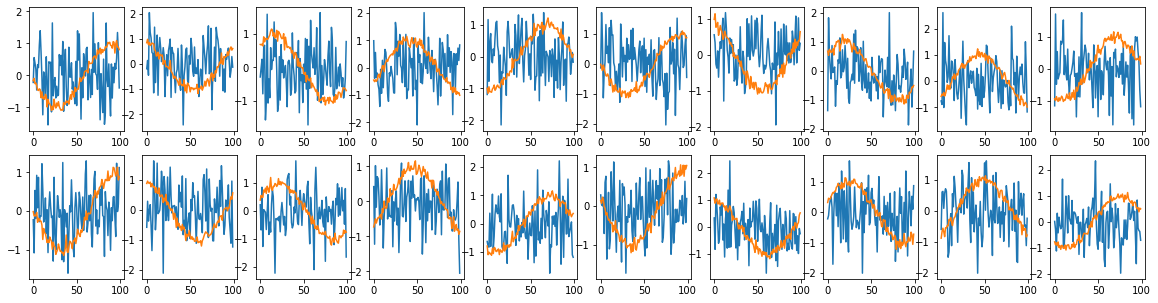

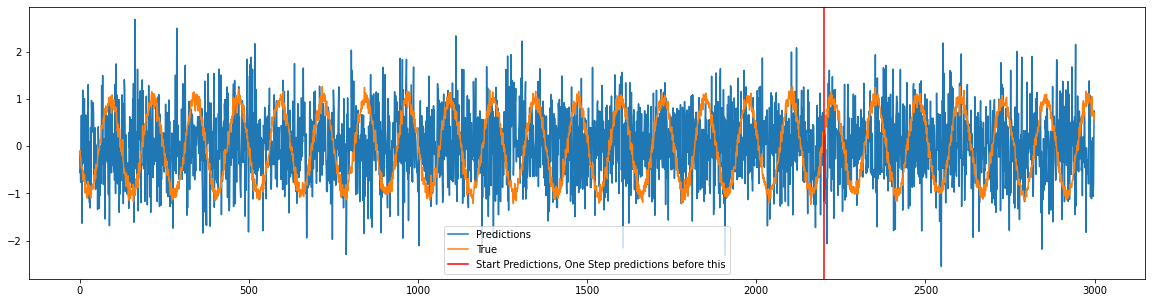

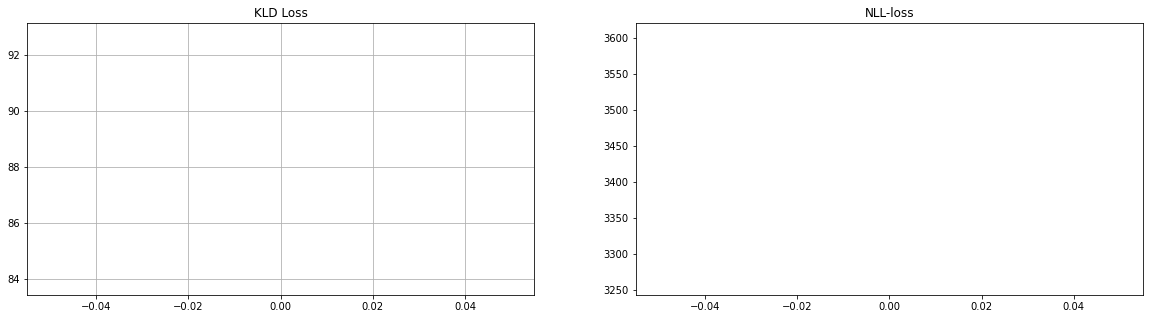

0.001


Epoch Loss: -1815.6858


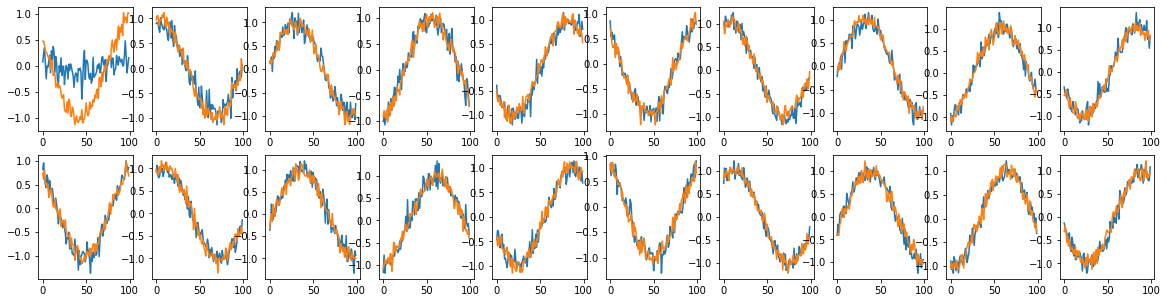

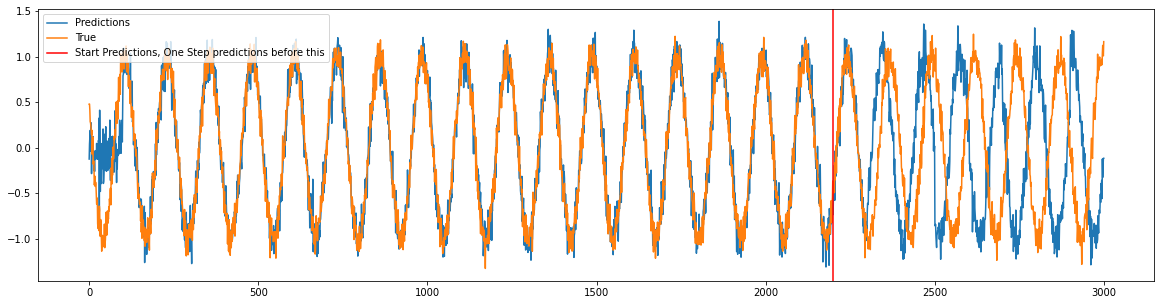

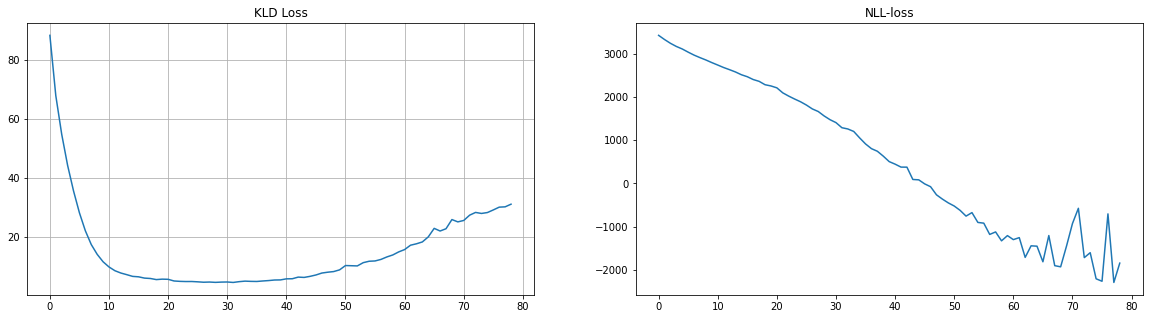

0.001


Epoch Loss: -2011.9519


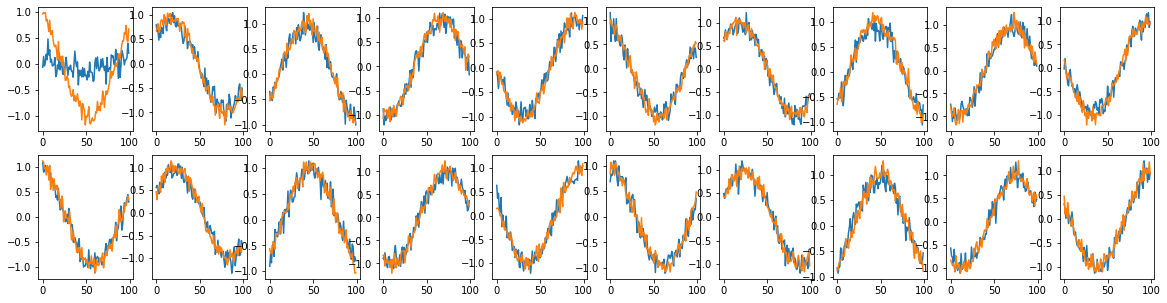

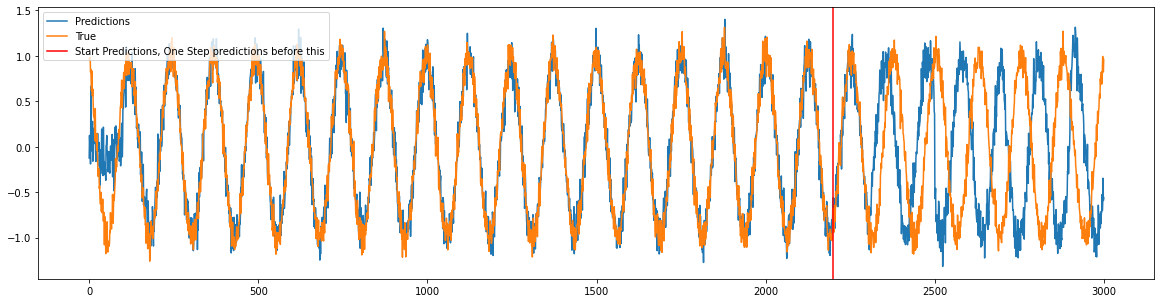

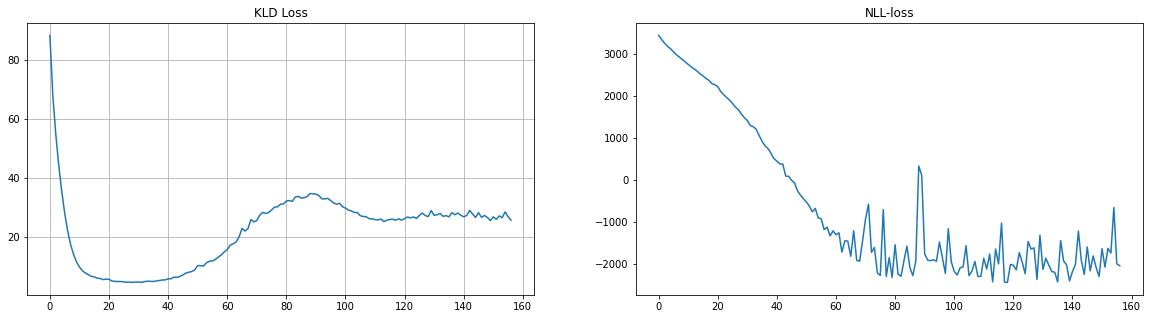

0.001


Epoch Loss: 3512.8008


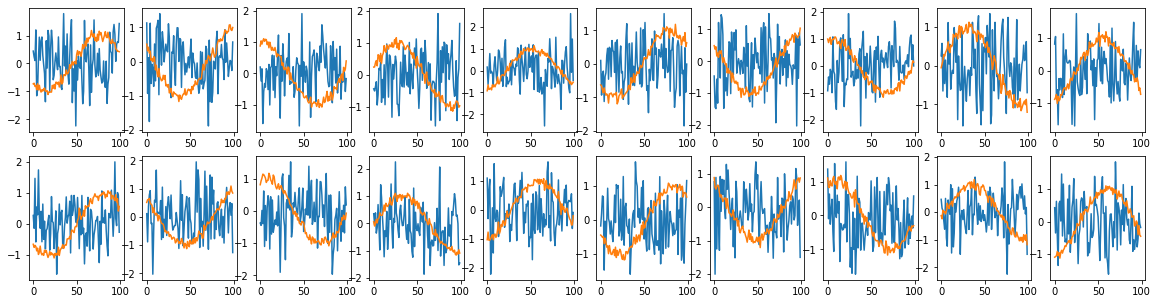

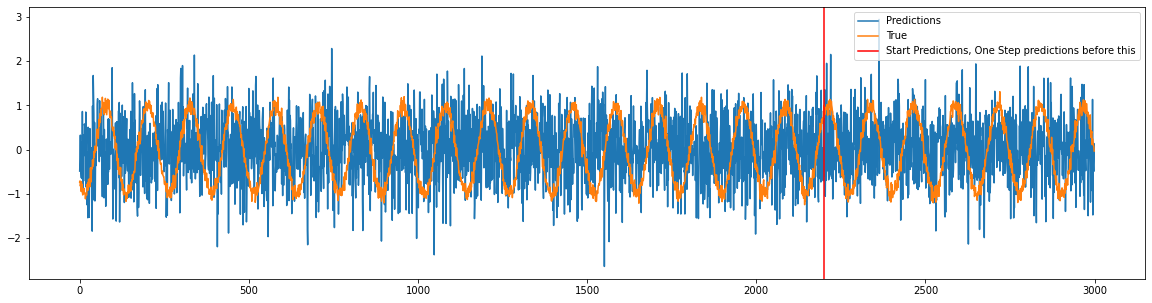

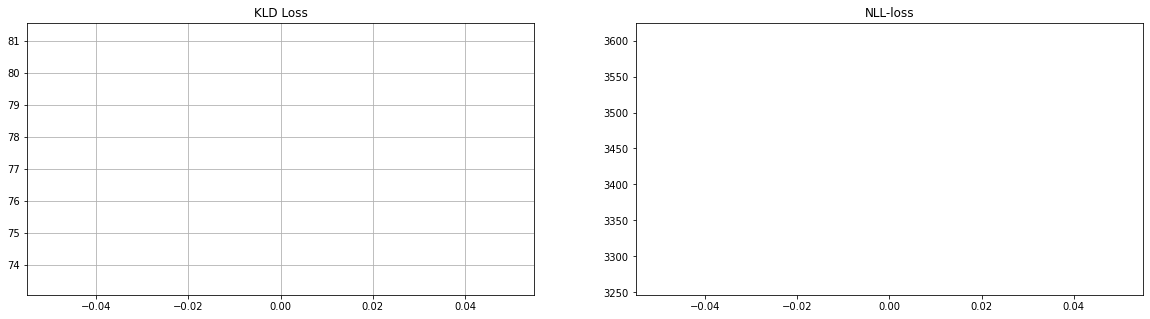

0.001


Epoch Loss: -2101.5867


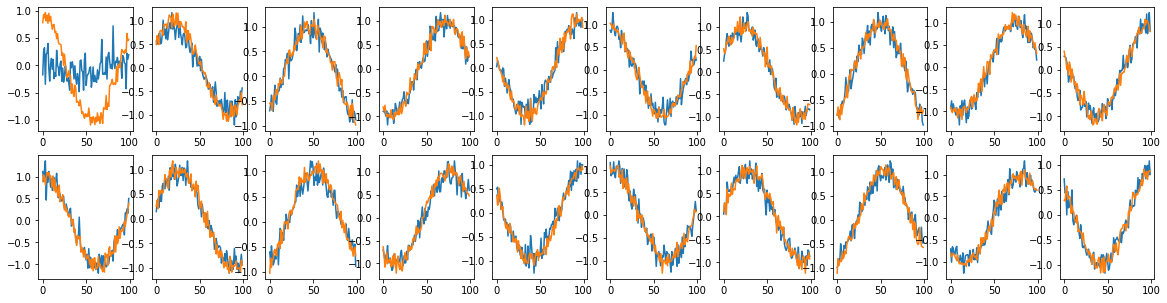

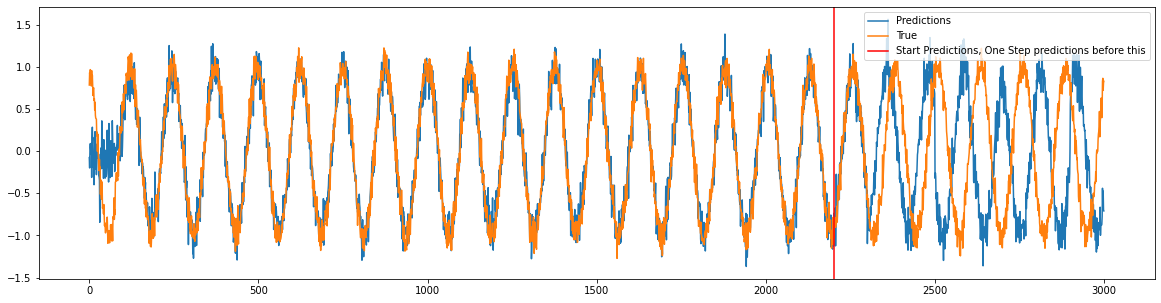

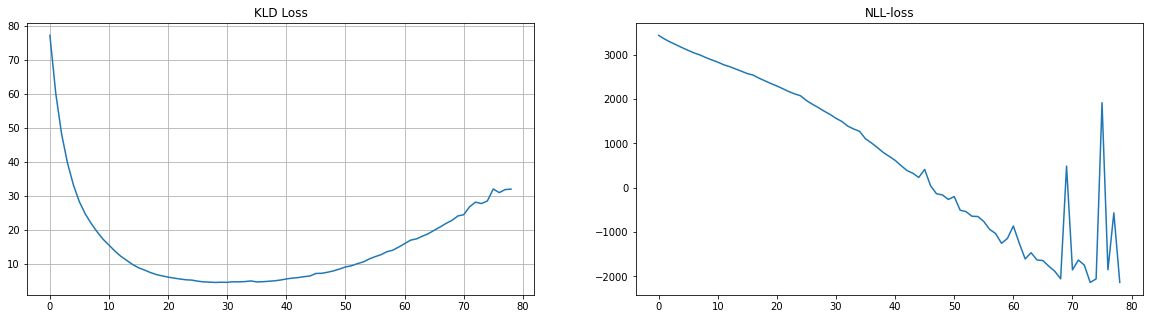

0.001


Epoch Loss: -1620.1235


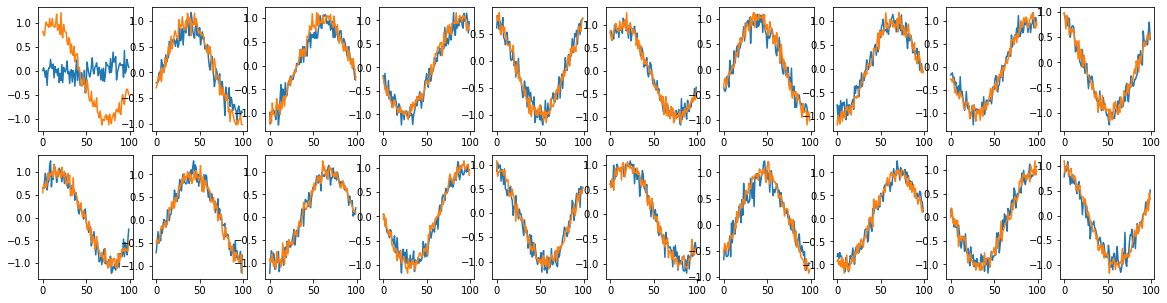

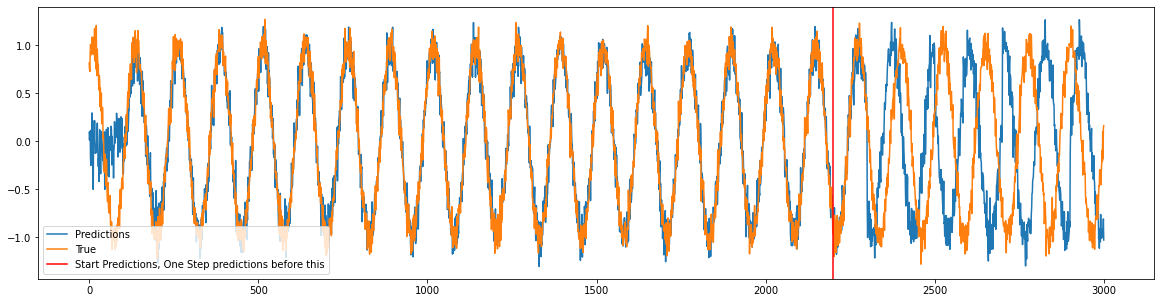

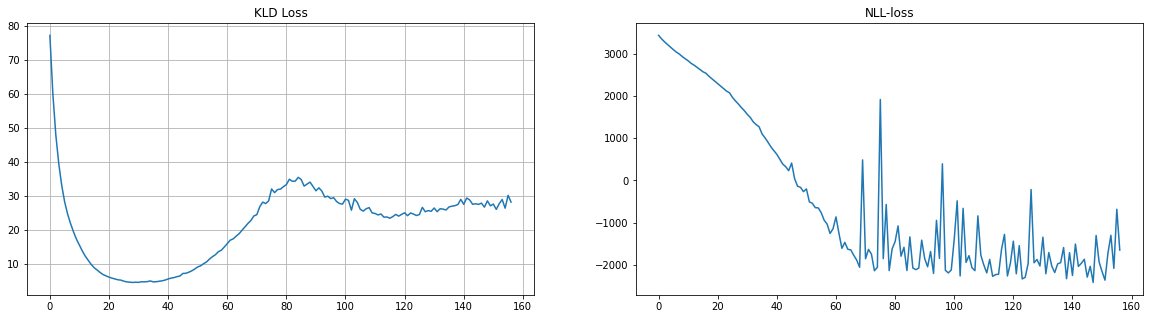

In [34]:
x=next(iter(train_loader_sinus)).float().to(device)
x=x.view(batch_size, timeblocks, -1)

modelVRNN = VRNN(x.shape[-1], x_batch=x.shape[0], h_dim = 100, z_dim = 28).to(device)
modelSRNN = SRNN(x.shape[-1], x_batch=x.shape[0], h_dim = 100, z_dim = 28).to(device)

print_every = 78
clip = 10
n_epochs = 3
modelVRNN, lossKLD_histVRNN, lossNLL_histVRNN = trainer(modelVRNN, print_every, clip, n_epochs)
modelSRNN, lossKLD_histSRNN, lossNLL_histSRNN = trainer(modelSRNN, print_every, clip, n_epochs)

Epoch Loss: -2125.9883


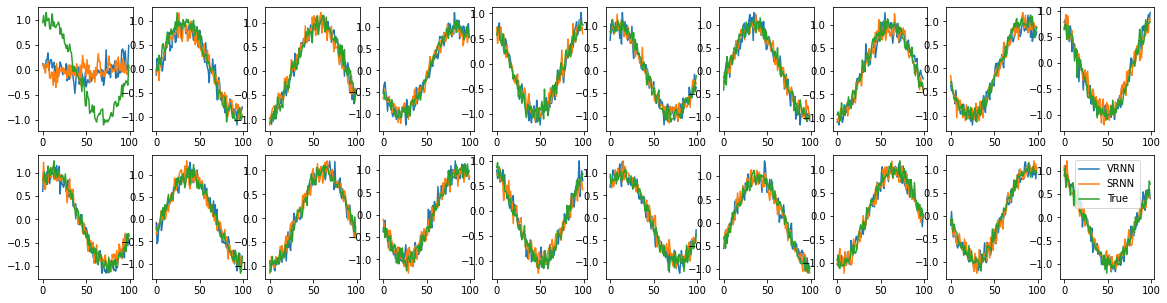

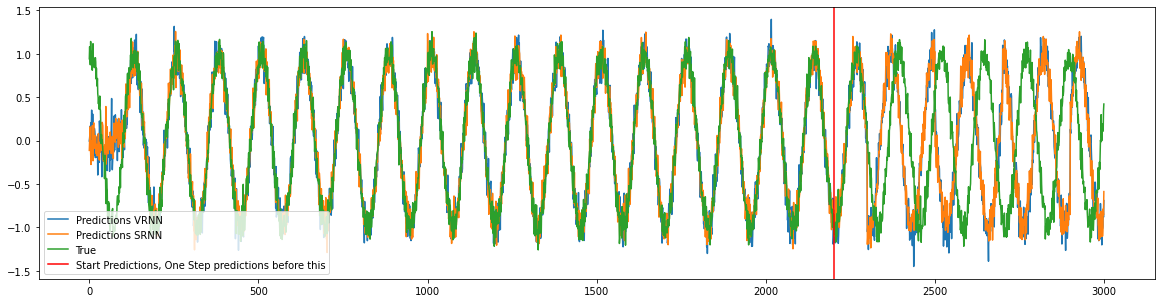

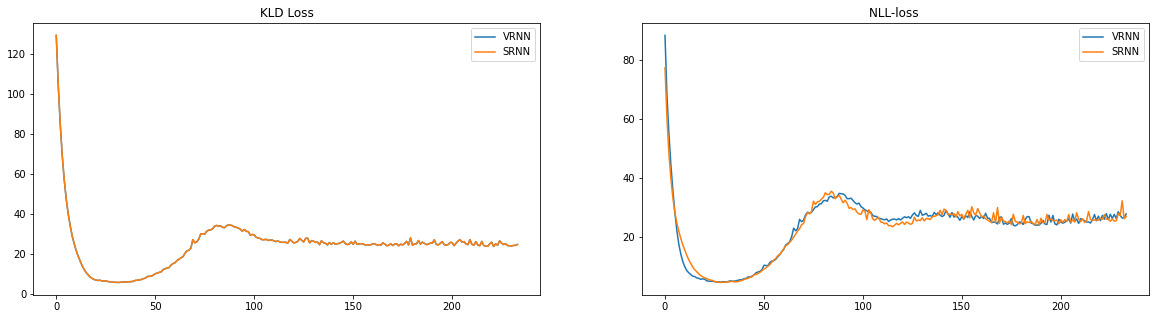

In [37]:
for model in [modelVRNN,modelSRNN]:
  model.eval()

xtest=next(iter(test_loader_sinus)).to(device)
xtest = scale_to_zero_one(xtest, xtest, reverse=False, transform=transform_x)

print('Epoch Loss: ' + str(np.array(train_loss).mean()))

namelist = ['VRNN','SRNN']
fig, ax = plt.subplots(2, 10, figsize = (20,5))
for model, name in zip([modelVRNN,modelSRNN],namelist):
  sample = model.OnestepPredict(xtest.float())
  for i in range(0,10):
    ax[0,i].plot(scale_to_zero_one(sample[i][0], xtest, reverse=True, transform=transform_x).cpu().numpy(), label = name)

  for i in range(0,10):
    ax[1,i].plot(scale_to_zero_one(sample[i+10][0], xtest, reverse=True, transform=transform_x).cpu().numpy(), label = name)
for i in range(0,10):
  ax[0,i].plot(scale_to_zero_one(xtest[0][i], xtest, reverse=True, transform=transform_x).cpu().numpy(), label = 'True' )
  ax[1,i].plot(scale_to_zero_one(xtest[0][i+10], xtest, reverse=True, transform=transform_x).cpu().numpy(),label = 'True')
plt.legend()

tsteps=3*timeblocks//4



plt.figure(figsize=(20,5))

models =[modelVRNN,modelSRNN]
for model, name in zip([modelVRNN,modelSRNN], namelist):
  predictions=[]
  preds = model.PredictionAfterTsteps(xtest.float(), tsteps=tsteps)
  for i in range(0,len(preds)):
    predictions.append(preds[i][0].cpu().numpy())
  plt.plot(np.ravel(np.array(predictions)),label='Predictions '+name)
plt.plot(xtest.view(batch_size,-1)[0].cpu(),label='True')
plt.axvline(x=xtest[0,:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
plt.legend()

fig, ax = plt.subplots(1, 2, figsize = (20,5))
for lossKLD, name in zip([lossKLD_histVRNN, lossKLD_histSRNN], namelist):
  ax[0].plot(lossKLD_hist, label = name)
  ax[0].grid()
  ax[0].title.set_text('KLD Loss')
for lossNLL_hist, name in zip([lossKLD_histVRNN, lossKLD_histSRNN], namelist):
  ax[1].plot(lossNLL_hist, label = name)
  ax[1].title.set_text('NLL-loss ')
ax[0].legend()
ax[1].legend()

plt.show()